# Imports

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import cv2
import numpy as np

from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt
from gan_package.gan import GAN
from gan_package.vanillaGAN import VanillaGAN_Generator, VanillaGAN_Discriminator
from gan_package.dcGAN import DCGAN_Generator, DCGAN_Discriminator
from datasets import dataloader

ModuleNotFoundError: No module named 'cv2'

# Load MNIST dataset

In [ ]:
# transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((256, 256)),transforms.Normalize((0.5,), (0.5,))])
# dataset = datasets.MNIST(root='.', train=True, transform=transform, download=True)
# dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

# Get shape of data, declare size of latent vector (from which we generate images)

In [ ]:
IMG_SHAPE = dataloader.dataset[0][0].shape
N_OUT = torch.prod(torch.tensor(IMG_SHAPE))
LATENT_DIM = 100

In [3]:
IMG_SHAPE

torch.Size([3, 256, 256])

# Instantiation of models, optimizers and loss

In [3]:
generator = DCGAN_Generator()
discriminator = DCGAN_Discriminator(num_channels=3, feature_maps_size=64, n_out=1)
gan = GAN(generator, discriminator)

In [4]:
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [5]:
gan.train(dataloader=dataloader,
          discriminator_optimizer=optimizer_D,
          generator_optimizer=optimizer_G,
          criterion=criterion,
          num_epochs=10)

 20%|██        | 1/5 [03:53<15:33, 233.38s/it]

In [2]:
generator = VanillaGAN_Generator(latent_dim=LATENT_DIM, img_shape=IMG_SHAPE, n_out=N_OUT)
discriminator = VanillaGAN_Discriminator(img_shape=IMG_SHAPE)
gan = GAN(generator=generator, discriminator=discriminator)

criterion = nn.BCELoss()

generator_optimizer = optim.Adam(generator.parameters(), lr=0.0002)
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)

NameError: name 'VanillaGAN_Generator' is not defined

# Test of Generator output shape (if it is compatible with shape of original images)

In [81]:
latent_dim=100
num_channels=3
batch_size=64
img_shape = (3, 256, 256)
n_out = int(torch.prod(torch.tensor(img_shape)))
generator = VanillaGAN_Generator(latent_dim=latent_dim, 
                                 img_shape=img_shape, 
                                 n_out=n_out)

# Assume input shape: (batch_size, latent_dim)
input_shape = (batch_size, 100)

# Forward pass
output = generator(torch.randn(input_shape))

# Get the output shape
output_shape = output.shape

print(output_shape)

torch.Size([64, 3, 256, 256])


# Training loop

In [7]:
gan.train(dataloader=dataloader,
          discriminator_optimizer=discriminator_optimizer,
          generator_optimizer=generator_optimizer,
          criterion=criterion,
          num_epochs=10)

  0%|          | 0/5 [00:41<?, ?it/s]


KeyboardInterrupt: 

In [84]:
# num_epochs = 10

# for epoch in range(num_epochs):
#     for real_images in tqdm(dataloader):
        
#         batch_size = real_images.size(0)
        
#         z = torch.randn(batch_size, LATENT_DIM)
#         fake_images = generator(z)
        
#         # Train the discriminator
#         d_loss = train_discriminator(optimizer=discriminator_optimizer, 
#                                      discriminator=discriminator, 
#                                      criterion=criterion,
#                                      real_images=real_images, 
#                                      fake_images=fake_images)
        
#         # Train the generator
#         fake_images_outputs = discriminator(fake_images)
        
#         g_loss = train_generator(optimizer=generator_optimizer, 
#                                  criterion=criterion, 
#                                  fake_images=fake_images, 
#                                  fake_images_outputs=fake_images_outputs)
        

 80%|████████  | 4/5 [00:11<00:02,  2.82s/it]

# Test generator power

In [ ]:
import torch
import torchvision.transforms as transforms

transform = transforms.ToPILImage()

# Convert the tensor to a PIL image
image_pil = transform(fake_image)

TypeError: Invalid shape (3, 256, 256) for image data

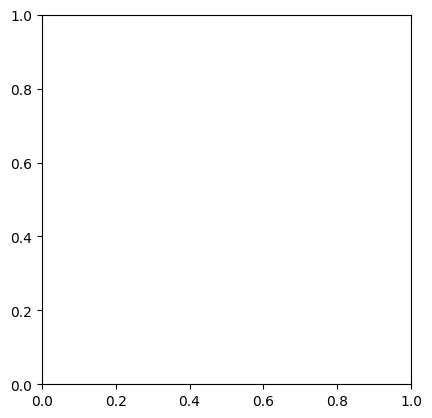

In [12]:
batch_size = 256
z = torch.randn(batch_size, LATENT_DIM)
fake_images = generator(z)
fake_image = fake_images[0].detach().numpy()
fake_image = fake_image.squeeze()
import torch
import torchvision.transforms as transforms

transform = transforms.ToPILImage()

# Convert the tensor to a PIL image
image_pil = transform(fake_image)
plt.imshow(fake_image)
# plt.imshow(fake_image, cmap='gray', num_channels=3)
plt.show()